In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sqlite3
import sklearn.linear_model as linear
import scipy.stats as stats

from bk_modeling import *
from bk_eda import *

pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid")

## Model Building

Now that I have finished ETL and EDA, it's time to move on to model building. Again, the goal will be to build a model that best predicts the average salary of the contracts free agents will sign.

I will start by loading in the data from the database.

In [2]:
con = sqlite3.connect('data.db')

In [3]:
query = """
SELECT 
    p.name, c.year, p.position, p.height, p.weight,
    c.age, c.year-p.rookie_year,
    s.games, s.minutes, s.pts, s.trb, s.ast, s.stl, s.blk, s.tov, s.fg, s.fg_per, s.three_fg, s.three_fg_per,
    s.efg_per, s.ft_per, 
    c.type, c.chg_team, c.length, c.avg_dollars
FROM contracts c
JOIN players p
    ON c.id=p.id
JOIN stats s
    ON c.id=s.id AND c.year=s.year
"""

contracts = pd.DataFrame(con.execute(query),
                         columns=['player', 'year', 'position', 'height', 'weight',
                                  'age', 'years_exp',
                                  'games', 'min', 'pts', 'rbs', 'ast', 'stl', 'blk', 'tov', 'fg', 'fg_per',
                                  'three_fg', 'three_per', 'efg_per', 'ft_per',
                                  'type', 'chg_team', 'length', 'avg_dollars'])

In [4]:
contracts.head()

,player,year,position,height,weight,age,years_exp,games,min,pts,...,fg,fg_per,three_fg,three_per,efg_per,ft_per,type,chg_team,length,avg_dollars
0,Klay Thompson,2019,SG,78,215,29.40,7,78,34.00,21.50,...,8.40,0.47,3.10,0.40,0.55,0.82,UFA,0,5,37980720
1,Tobias Harris,2019,PF,80,226,26.90,7,82,34.70,20.00,...,7.50,0.49,1.90,0.40,0.55,0.87,UFA,0,5,36000000
2,Khris Middleton,2019,SF,79,222,27.80,6,77,31.10,18.30,...,6.60,0.44,2.30,0.38,0.52,0.84,UFA,0,5,35500000
3,Kevin Durant,2019,SF,82,240,30.80,11,78,34.60,26.00,...,9.20,0.52,1.80,0.35,0.57,0.89,UFA,1,4,41063925
4,Jimmy Butler,2019,SF,79,230,29.80,7,65,33.60,18.70,...,6.40,0.46,1.00,0.35,0.50,0.85,UFA,1,4,35197650


### Mean Model

The simplest model that can be used is a mean model. In this model, we would simply predict each player would get the mean salary.

In [5]:
print('Mean Average Salary:', contracts['avg_dollars'].mean())

Mean Average Salary: 6772490.295774648


In a practical sense, using this model in this context is rather silly. Top tier players would laugh at an offer like this and we would grossly overpaying for a lot of other players.

We can also take a look at the standard deviation of the mean model.

In [6]:
print('Std of Average Salary:', contracts['avg_dollars'].std())

Std of Average Salary: 7879993.542130161


The standard deviation of the avg_dollars variable is almost 8 million dollars! This is an extremely high standard deviation, as it would mean on average, the predicted average salary would be off by 7.8 million dollars. The goal when I build a linear regression model is to lower this standard deviation drastically.

### Linear Regression

I will start by predicting the sign of the coefficients for the different features by predicting how the different features will influence `avg_dollars`. Most of these predictions come directly from EDA.

* **height** - positive: For the most part, I think taller players will make more more than shorter players, with the caveat that the might be a dip in salary when players are on the extreme tall end.
* **weight** - unclear: At the moment, I have no real prediction for how weight will affect the model.
* **age** - positive: For the most part, I think older players will make more money than shorter players, with the caveat that players are likely to earn the most money during there late-middle years.
* **games** - positive: I think that players who play more games will earn more money than those who play less.
* **minutes** - positive: I think that players who play more minutes will earn more money than those who play less.
* **points** - positive: I think that players who score more points will earn more money than those who score less.
* **rebounds** - positive: I think that players who get more rebounds will earn more money than those who get less.
* **assists** - positive: I think that players who get more assists will earn more money than those who get less.
* **steals** - positive: I think that players who get more steals will earn more money than those who get less.
* **blocks** - positive: I think that players who get block more shots will earn more money than those who block less.
* **turnovers** - positive: I think that players who turn the ball over more will earn more money than those who turn the ball over less. While this is counterintuitive, this is the relationship that was discovered in EDA. Again, my hypothesis is that better players have the ball more and having the ball more will lead to more turnovers. (In my opinion, this relationship between turning the ball over and earning more money is a great "Correlation does not equal causation" example.)
* **field goal percentage** - little impact: As I saw in EDA, players with a range of different field goal percentages had a range of different salaries. Thus, I don't think this statistic will have much impact on the model.
* **three point field goals** - positive: I think that players who make more three point shots will make more money than those who make less.
* **three point percentage** - little impact: As I saw in EDA, players with a range of different three point percentage
* **effctive field goal percentage** - little impact: As I saw in EDA, players with a range of different effective field goal percentages had a range of different salaries. Additionally, this is just a weighted version of field goal percentage. Thus, I don't think this statistic will have much impact on the model.
* **free throw percentage** - positive: Albeit slight, I think that players who shoot a higher percentage from the free throw line will make more money than those who shoot worse from the free throw line.
* **type** - I think that players who are signing restricted free agent deals will need to be paid a little more than unrestricted free agents.
* **chg_team** - I think that players who stay with the same team will make more money than those who change teams.
* **length** - I think that players who sign longer contracts will make more money than those who sign shorter contracts.

Before starting to build my first model, I need to create one hot encodings for the position and type variables.

First for `position`

In [7]:
contracts = pd.concat([contracts, pd.get_dummies(contracts['position'])], axis=1)

In [8]:
contracts.head()

,player,year,position,height,weight,age,years_exp,games,min,pts,...,ft_per,type,chg_team,length,avg_dollars,C,PF,PG,SF,SG
0,Klay Thompson,2019,SG,78,215,29.40,7,78,34.00,21.50,...,0.82,UFA,0,5,37980720,0,0,0,0,1
1,Tobias Harris,2019,PF,80,226,26.90,7,82,34.70,20.00,...,0.87,UFA,0,5,36000000,0,1,0,0,0
2,Khris Middleton,2019,SF,79,222,27.80,6,77,31.10,18.30,...,0.84,UFA,0,5,35500000,0,0,0,1,0
3,Kevin Durant,2019,SF,82,240,30.80,11,78,34.60,26.00,...,0.89,UFA,1,4,41063925,0,0,0,1,0
4,Jimmy Butler,2019,SF,79,230,29.80,7,65,33.60,18.70,...,0.85,UFA,1,4,35197650,0,0,0,1,0


And for `type`

In [9]:
contracts = pd.concat([contracts, pd.get_dummies(contracts['type'])], axis=1) 

In [10]:
contracts.head()

,player,year,position,height,weight,age,years_exp,games,min,pts,...,chg_team,length,avg_dollars,C,PF,PG,SF,SG,RFA,UFA
0,Klay Thompson,2019,SG,78,215,29.40,7,78,34.00,21.50,...,0,5,37980720,0,0,0,0,1,0,1
1,Tobias Harris,2019,PF,80,226,26.90,7,82,34.70,20.00,...,0,5,36000000,0,1,0,0,0,0,1
2,Khris Middleton,2019,SF,79,222,27.80,6,77,31.10,18.30,...,0,5,35500000,0,0,0,1,0,0,1
3,Kevin Durant,2019,SF,82,240,30.80,11,78,34.60,26.00,...,1,4,41063925,0,0,0,1,0,0,1
4,Jimmy Butler,2019,SF,79,230,29.80,7,65,33.60,18.70,...,1,4,35197650,0,0,0,1,0,0,1


As the value for change team is already 0 for resigning with the same team and 1 for changing teams, there is no need to make one hot encodings for this variable.

As our target variable is `avg_dollars`, I will go ahead and set the y variable to `avg_dollars`

In [11]:
y = 'avg_dollars'

I will start by creating an initial 'all variables' model.

In [12]:
X = ['PF', 'PG', 'C', 'SG', 'height', 'weight', 'age', 'games', 'min', 'pts',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'fg_per', 'three_fg', 'three_per', 'efg_per',
     'ft_per', 'RFA', 'chg_team', 'length']

In [13]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-30,137,144.70","-55,654,587.43","-10,465,636.32"
1,PF,"-743,517.21","-2,429,990.85","860,811.39"
2,PG,"-1,624,146.92","-3,457,641.05","-75,719.12"
3,C,"-1,381,603.17","-3,570,069.82","650,040.83"
4,SG,"-595,019.91","-2,175,096.12","650,641.82"
5,height,"300,878.36","71,731.21","594,451.19"
6,weight,"-1,059.14","-35,946.31","26,055.11"
7,age,"177,891.14","36,552.53","313,127.30"
8,games,"18,156.57","-14,356.10","49,587.89"
9,min,"-416,682.67","-595,901.07","-225,613.74"


There is a lot going on in this initial model. The value for $R^2$ is 0.79, which is pretty good to start. The $\bar{R^2}$, which takes into account the number of features in the model, is also at a good starting value of 0.77. The $\sigma$ is 3.7 million dollars, which is almost half of the standard devation of avg_dollars originally.

I hesitate to look to much at the coefficients and residuals of this model simplying because there are so many variables. It is likely that some of these variables are not super impactful in predicting the average salary. Thus, these factors are likely influencing the coefficient values of the other features.

Thus, I will try rerunning the model using only the features that I think have a more significant impact on the model.

In [14]:
X = ['height', 'age', 'min', 'pts',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length']

In [15]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-31,054,689.69","-47,274,222.51","-14,451,908.32"
1,height,"278,859.28","80,553.03","478,633.96"
2,age,"151,148.06","6,140.92","242,950.69"
3,min,"-342,145.81","-510,114.77","-191,557.81"
4,pts,"1,093,174.05","812,866.87","1,305,585.83"
5,rbs,"78,074.51","-411,267.49","625,731.18"
6,ast,"1,142,177.79","635,876.08","1,895,531.37"
7,stl,"1,880,840.35","-176,992.43","3,679,721.54"
8,blk,"-1,184,589.92","-2,918,829.96","738,778.79"
9,tov,"-1,676,684.10","-3,701,071.48","172,696.21"


In this second model, I reduced the number of features from 23 to 13 with very little impact on the value of $R^2$, $\bar{R^2}$, and $\sigma$. I removed the four shooting percentage features, the position features, weight, and games. It is here I will begin looking at coefficients and residuals.

Many of the coefficients have the same sign that I predicted before starting to build the model. Minutes, blocks, and steals all have a negative coefficients, which very much surprises me. Also, being a Restricted Free Agent decreases avg_dollars and changing teams increases salary, both of which surprise me.

The next thing that I want to do is look at the residual plots. This will help me to see if there are any trends in the errors that the model is making.

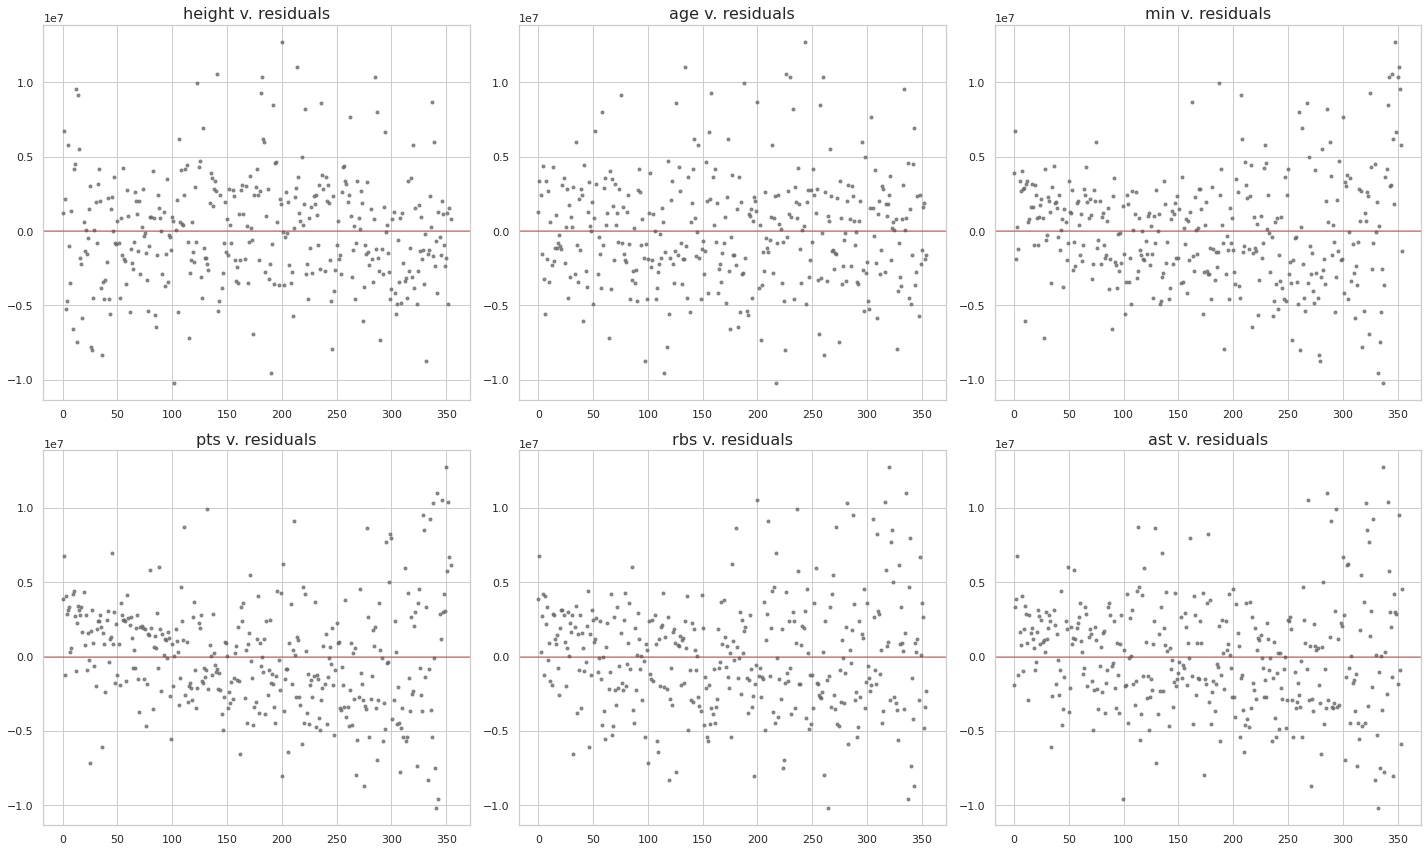

In [16]:
plot_residuals(contracts, ['height', 'age', 'min', 'pts', 'rbs', 'ast'], result, (2, 3), size=(20,12))

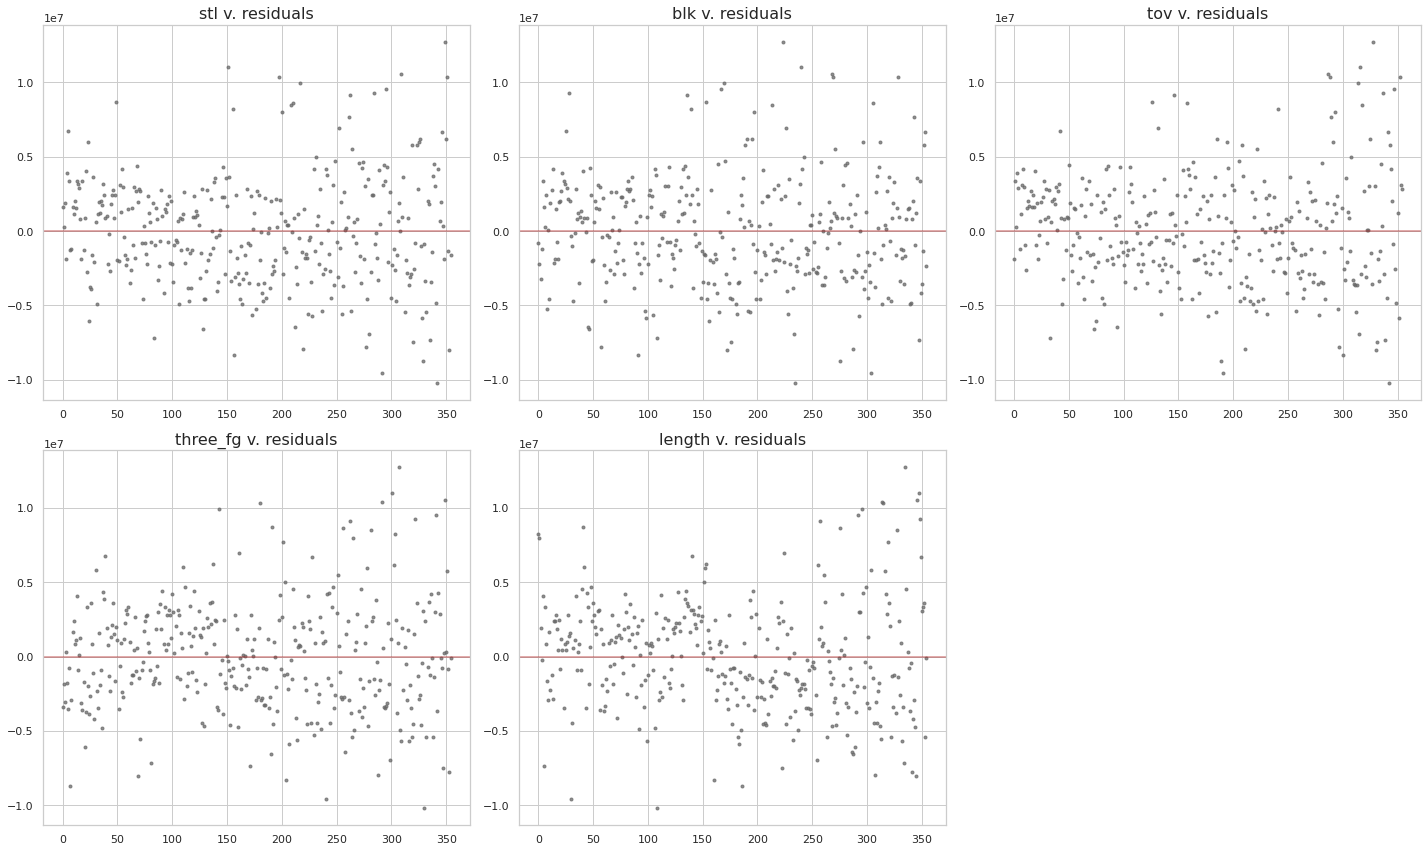

In [17]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

One thing that stands out from a bunch of these residual plots is that the errors are much larger for the higher values for the different variables. This is something that I want to keep an eye on and want to correct.

In EDA, I saw a curved relationships between `pts` and `avg_dollars` and between `min` and `avg_dollars`. Also, the residual plots for these features also have an upward curve. Thus, I want to try running the model with these features squared.

In [18]:
contracts['pts_sq'] = contracts['pts']**2
contracts['min_sq'] = contracts['min']**2

In [19]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length']

In [20]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-27,289,806.82","-40,760,856.94","-13,868,700.27"
1,height,"254,464.19","90,238.49","421,786.36"
2,age,"146,710.10","54,068.40","251,749.35"
3,min_sq,"-1,641.40","-4,692.38","1,864.69"
4,pts_sq,"42,457.11","35,623.38","49,405.04"
5,rbs,"23,835.27","-501,541.42","430,417.09"
6,ast,"979,313.80","421,988.70","1,543,678.30"
7,stl,"854,531.58","-658,056.07","2,407,870.17"
8,blk,"-1,315,837.91","-2,799,634.78","14,783.82"
9,tov,"-2,072,249.81","-3,533,891.31","-491,045.58"


This adjustment increased the values of $R^2$, $\bar{R^2}$, and $\sigma$. Let's take a look at the residual plot again.

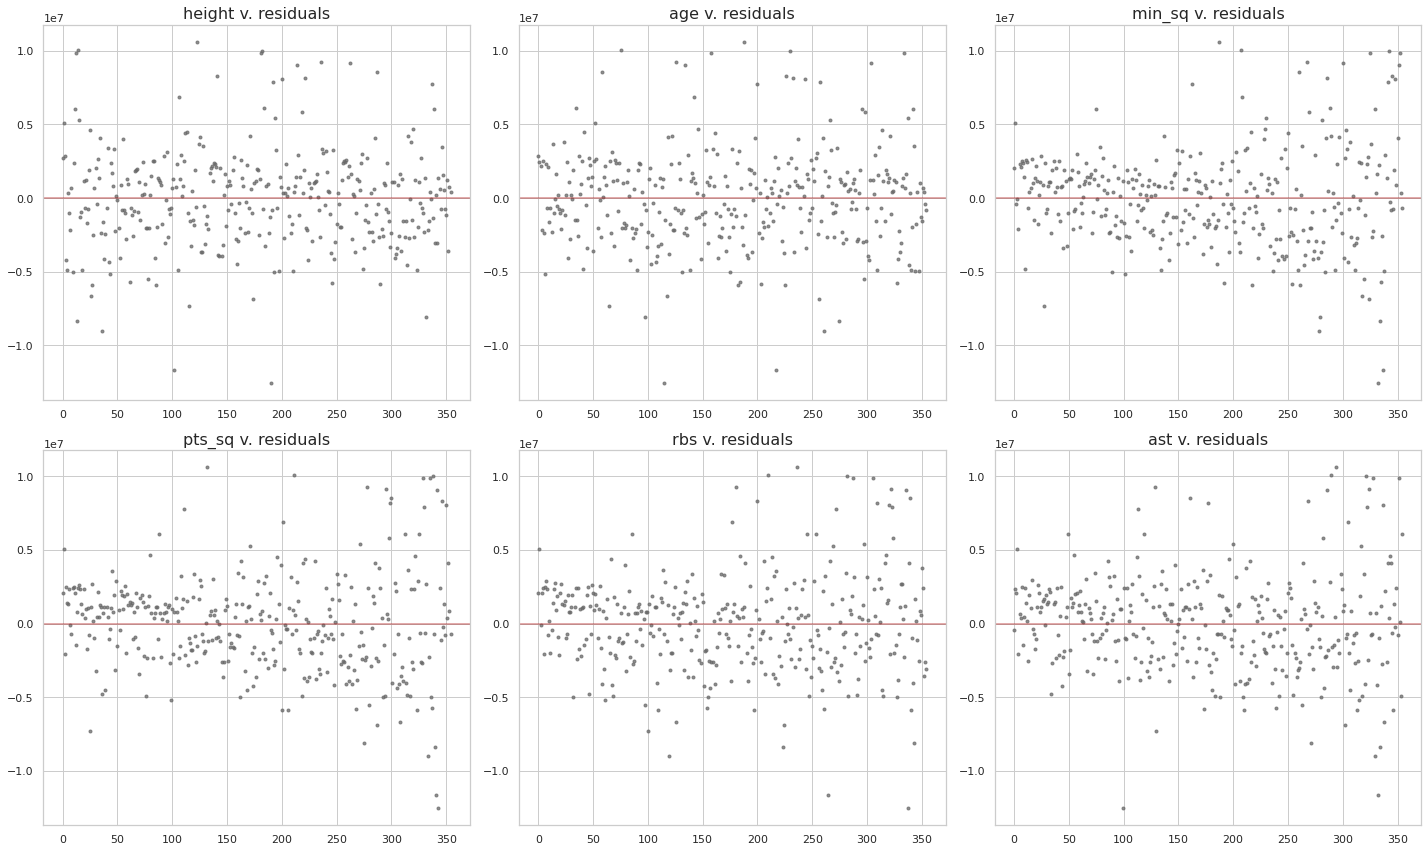

In [21]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs', 'ast'], result, (2, 3), size=(20,12))

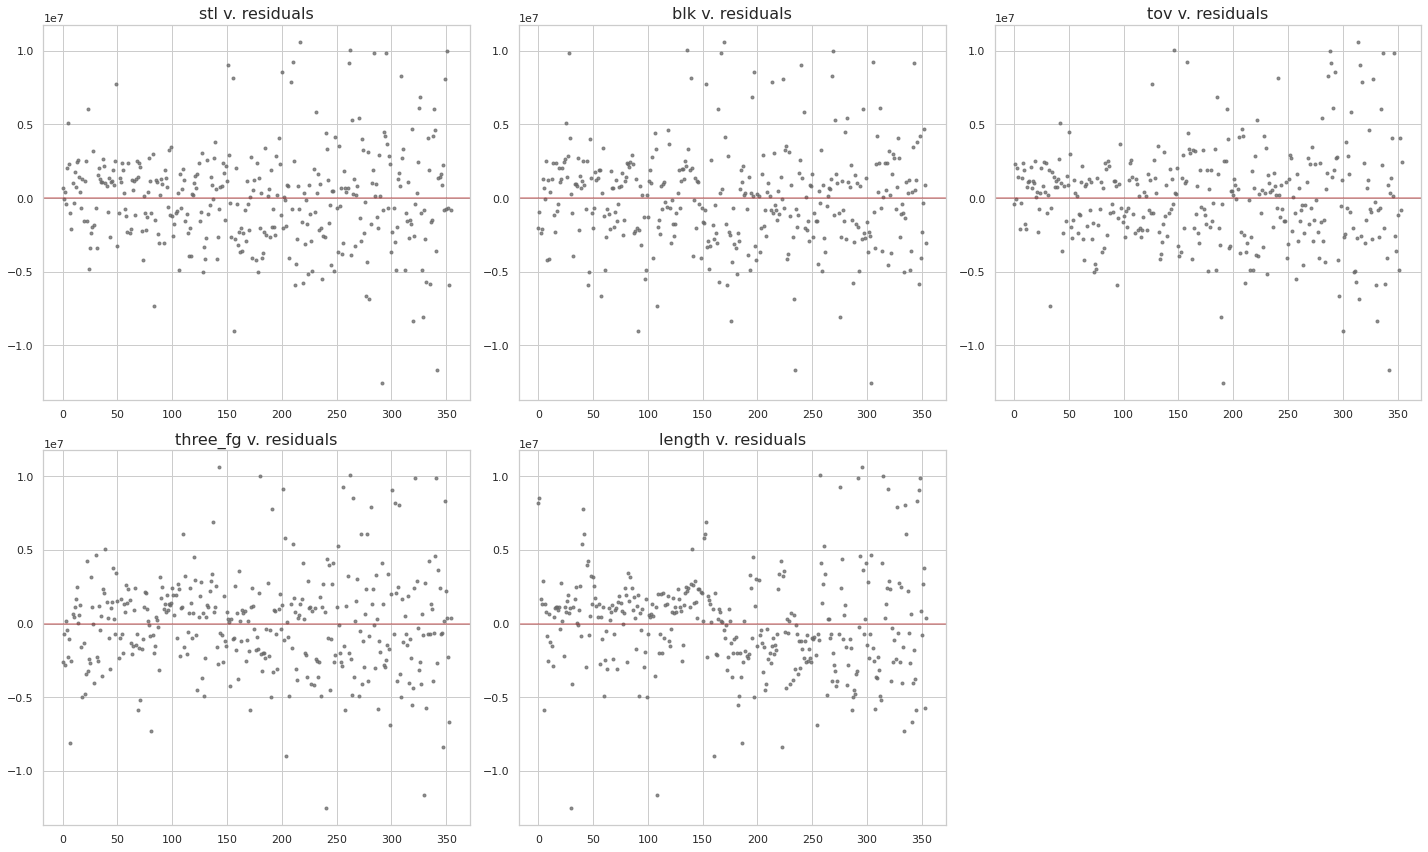

In [22]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

There seems to be a little bit less curve than there was previously in the min and pts errors.

The much larger errors on the higher order features is still something that I want to try and address next. Because the values of `avg_dollars` are so high, I want to try and take the log of average dollars and apply the model to these values.

In [23]:
contracts['log_avg_dollars'] = contracts['avg_dollars'].apply(lambda x: np.log(float(x)))

In [24]:
y = 'log_avg_dollars'
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length']

In [25]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,11.27,9.99,13.21
1,height,0.02,-0.01,0.03
2,age,0.03,0.02,0.04
3,min_sq,0.00,-0.00,0.00
4,pts_sq,0.00,0.00,0.00
5,rbs,0.04,-0.01,0.12
6,ast,0.04,-0.02,0.10
7,stl,0.17,-0.01,0.37
8,blk,-0.10,-0.30,0.06
9,tov,-0.05,-0.28,0.23


I was not fully sure what to expect from this model and I knew it would make the coefficients and results less interpretable, but I wanted to see if the effect this would have on $R^2$ and $\bar{R^2}$. Since these values are lower, there is no reason to use `log_avg_dollars` again.

In [26]:
y = 'avg_dollars'

**Interaction Terms**

One thing that I discussed at the end of the EDA section was that I want to incorporate some interaction terms into the model that related to positions. In basketball, players who play guard or small forward are often expected to get more assists, steals, and shoot more three point shots than power forwards and centers. Similarly, power fowards and centers are usually expected to get more rebounds, block more shots, and have a higher field goal percentage than guards and small forwards. Thus, I want to add some interaction terms into the model to see if this has any effect on the model.

To do so, I will start by making a binary feature `big`. If the player is a guard or small forward, then their value for big will be 0. If they are a power forward or center, their value will be one.

In [27]:
contracts['big'] = [1 if x[0] + x[1] != 0 else 0 for x in zip(contracts['PF'], contracts['C'])]

I will take the value counts just to see the distribution of "bigs" and "littles" in the data set.

In [28]:
pd.DataFrame(contracts['big'].value_counts())

,big
0,210
1,145


It looks like there are more "littles" in the data set, which makes sense because 3 positions make up "littles" while only 2 make up "bigs".

Now, I will add the interaction terms to the data set.

In [29]:
contracts['big:rbs'] = contracts['big'] * contracts['rbs']
contracts['big:blk'] = contracts['big'] * contracts['blk']
contracts['big:efg_per'] = contracts['big'] * contracts['efg_per']

contracts['big:ast'] = contracts['big'] * contracts['ast']
contracts['big:stl'] = contracts['big'] * contracts['stl']
contracts['big:three_fg'] = contracts['big'] * contracts['three_fg']

In [30]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'big:rbs', 'big:blk', 'big:efg_per',
     'big:ast', 'big:stl', 'big:three_fg']

In [31]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-25,598,989.51","-42,926,856.32","-10,936,548.82"
1,height,"232,262.39","38,823.98","447,517.09"
2,age,"141,138.74","37,131.72","246,642.48"
3,min_sq,"-1,708.14","-5,253.69","2,140.45"
4,pts_sq,"42,602.12","33,805.26","50,550.06"
5,rbs,"92,540.87","-721,183.66","786,882.86"
6,ast,"931,931.63","262,063.21","1,383,759.44"
7,stl,"1,192,827.88","-989,662.51","3,564,733.71"
8,blk,"-1,202,622.99","-4,955,185.86","2,383,734.28"
9,tov,"-2,041,243.36","-3,438,090.89","-258,269.41"


The value for $\sigma$ actually increased slightly. However, while the values for $R^2$ and $\bar{R^2}$ did not change, the both the low and upper bounds of the Bayesian Interval actually increased. Thus, I will leave the interaction terms in the model for now. 

Let's again take a look at the residual plots.

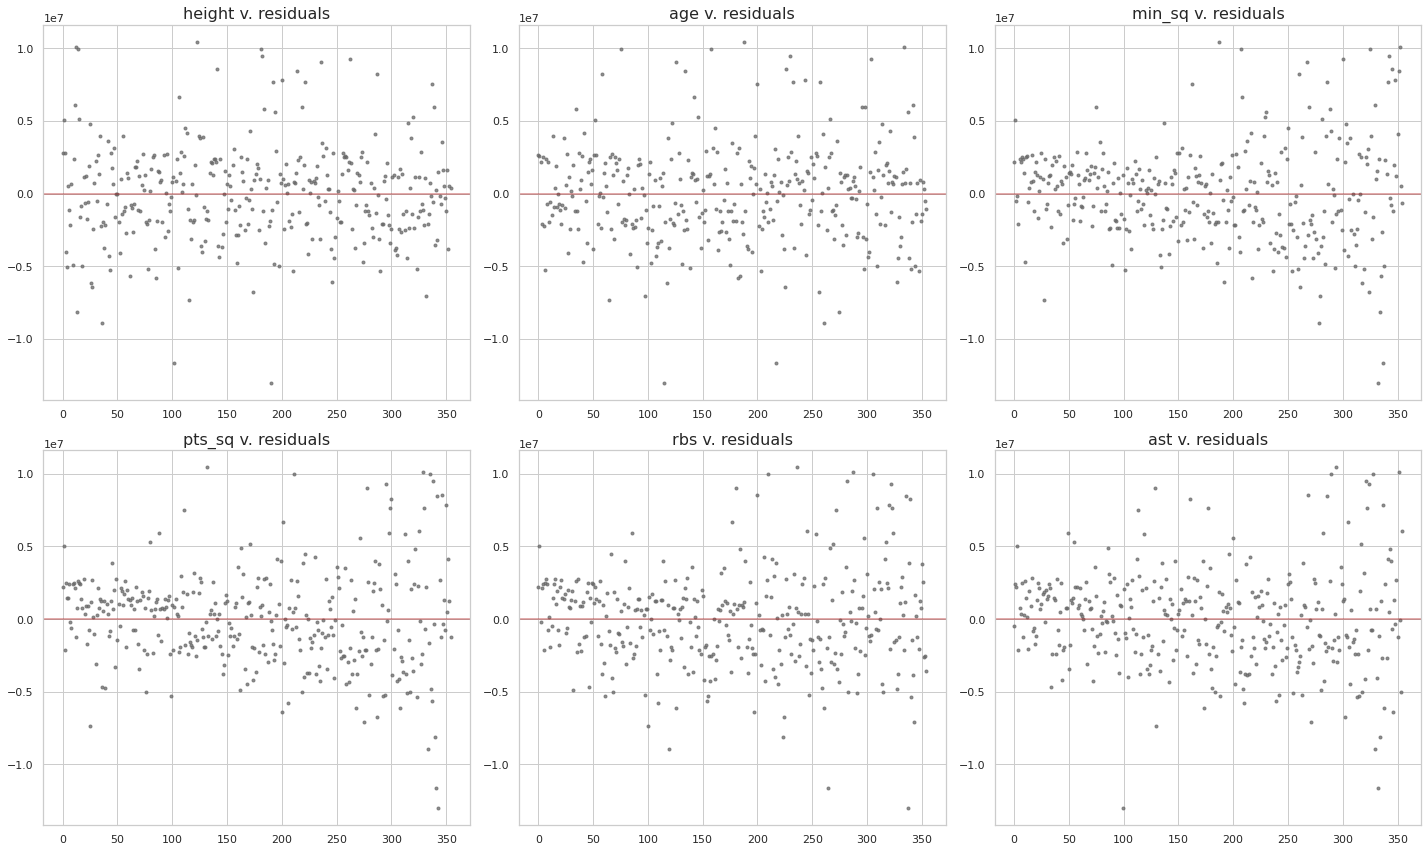

In [32]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs', 'ast'], result, (2, 3), size=(20,12))

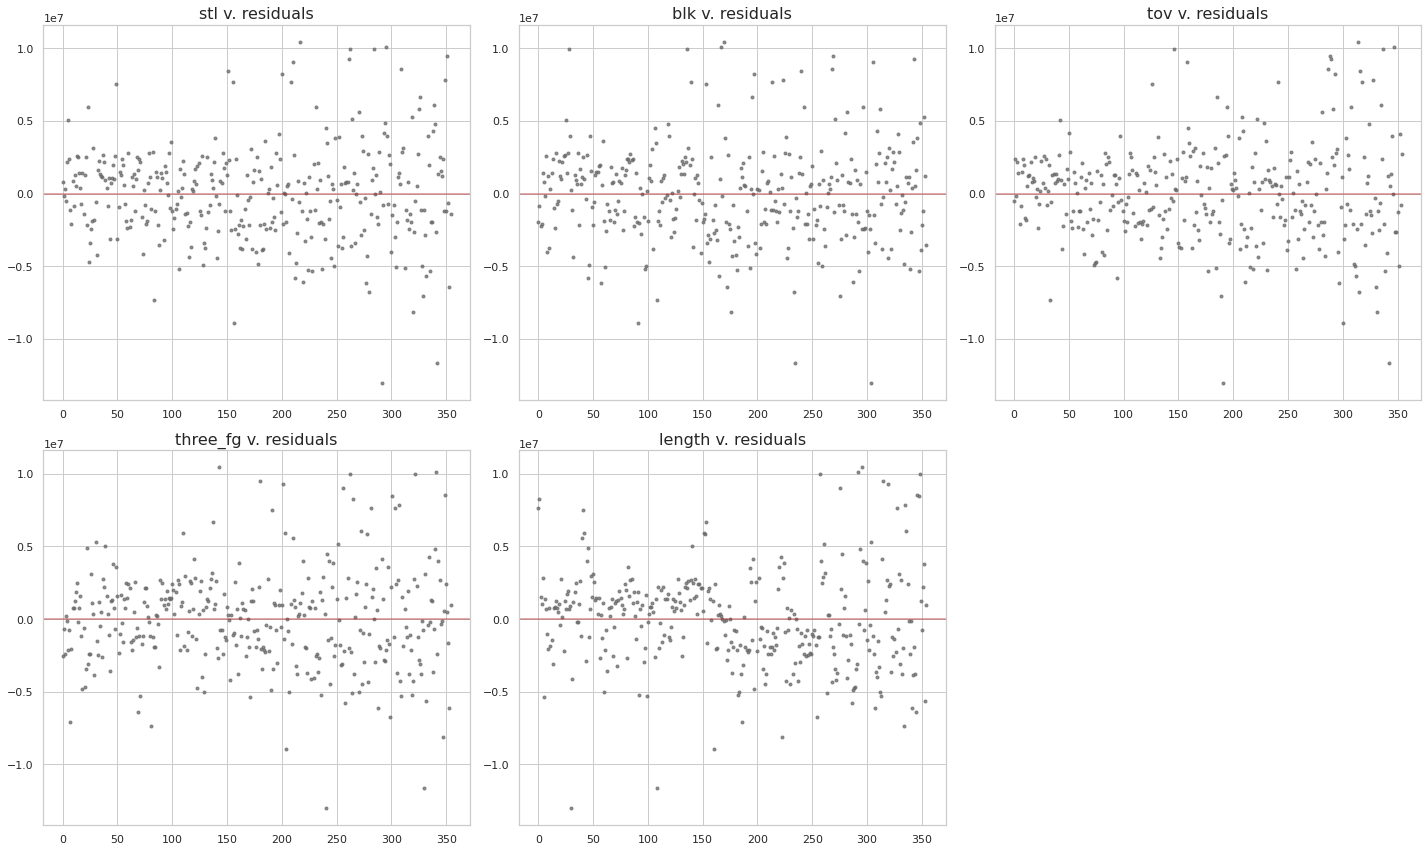

In [33]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

The residual plots still look much the same. I am still seeing the greater errors at the high end of the features.

Next, I want to try using height in the interaction term instead of position. As I noted early, position is often based upon height, and using the player's actual height will give us more control about which players are in each group.

To do this, I will make a short, medium and tall group. The short group will include players 76 inches and shorter (6'4 and shorter). The medium group will include players between 77 inches and 81 inches (6'5 to 6'9). The tall group will have players that are 82 inches and taller (6'10 and above).

In [34]:
contracts['short'] = [1 if x<=76 else 0 for x in contracts['height']]
contracts['tall'] = [1 if x>=82 else 0 for x in contracts['height']]
contracts['medium'] = [1 if x[0]+x[1] != 1 else 0 for x in zip(contracts['short'], contracts['tall'])]

Now I will check how many players are in each of the short, medium, and tall groups.

In [35]:
print('Number in the short group:', contracts['short'].value_counts()[1])
print('Number in the medium group:', contracts['medium'].value_counts()[1])
print('Number in the tall group:', contracts['tall'].value_counts()[1])

Number in the short group: 104
Number in the medium group: 181
Number in the tall group: 70


I will now create the new interaction features. I will only make interaction terms using the short and the tall groups because I only need to include n-1 binary features for this and the medium group has the most players in it.

In [36]:
contracts['short:rbs'] = contracts['short'] * contracts['rbs']
contracts['short:blk'] = contracts['short'] * contracts['blk']
contracts['short:efg_per'] = contracts['short'] * contracts['efg_per']
contracts['short:ast'] = contracts['short'] * contracts['ast']
contracts['short:stl'] = contracts['short'] * contracts['stl']
contracts['short:three_fg'] = contracts['short'] * contracts['three_fg']

contracts['tall:rbs'] = contracts['tall'] * contracts['rbs']
contracts['tall:blk'] = contracts['tall'] * contracts['blk']
contracts['tall:efg_per'] = contracts['tall'] * contracts['efg_per']
contracts['tall:ast'] = contracts['tall'] * contracts['ast']
contracts['tall:stl'] = contracts['tall'] * contracts['stl']
contracts['tall:three_fg'] = contracts['tall'] * contracts['three_fg']

I will now run the model using these new interaction terms instead of the position interaction terms.

In [37]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-13,605,592.62","-40,474,887.54","5,804,047.67"
1,height,"72,754.50","-179,649.65","428,629.94"
2,age,"146,281.14","53,784.94","251,371.38"
3,min_sq,"-3,650.54","-6,840.88",-283.94
4,pts_sq,"42,634.84","34,778.66","50,205.57"
5,rbs,"125,350.18","-369,725.76","498,355.46"
6,ast,"1,821,656.43","816,683.49","2,935,711.43"
7,stl,"858,624.88","-1,973,115.41","3,194,827.48"
8,blk,"-1,261,778.30","-4,648,317.87","1,674,185.50"
9,tov,"-1,815,892.10","-3,536,845.21","-510,326.92"


Using these new interaction terms slightly increased the values for $R^2$ and $\bar{R^2}$ and slightly decreased the value for $\sigma$. This means this is probably a better model than the model with the position-based interaction terms. Having a look at the residual plots again.

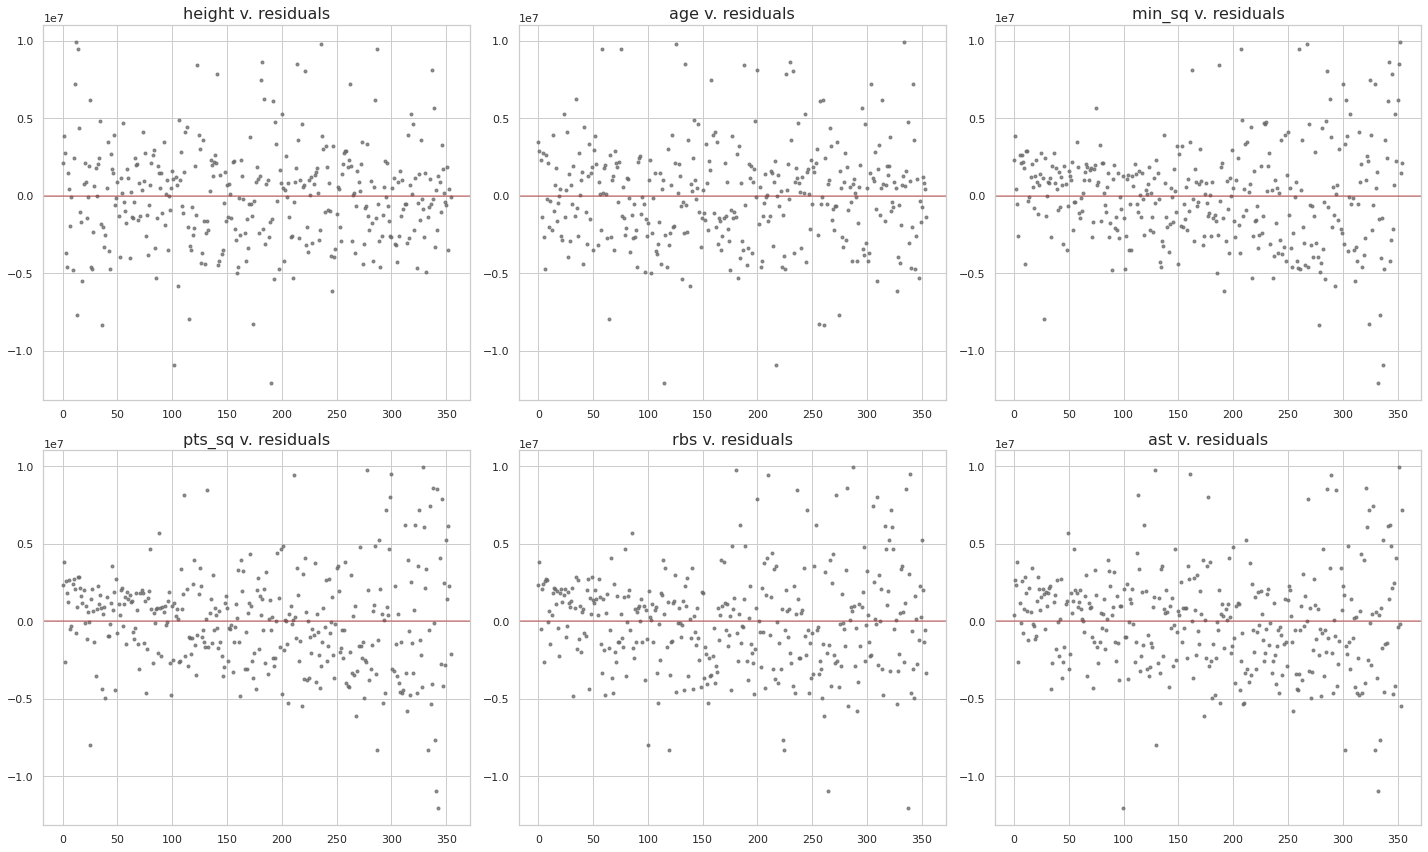

In [38]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs', 'ast'], result, (2, 3), size=(20,12))

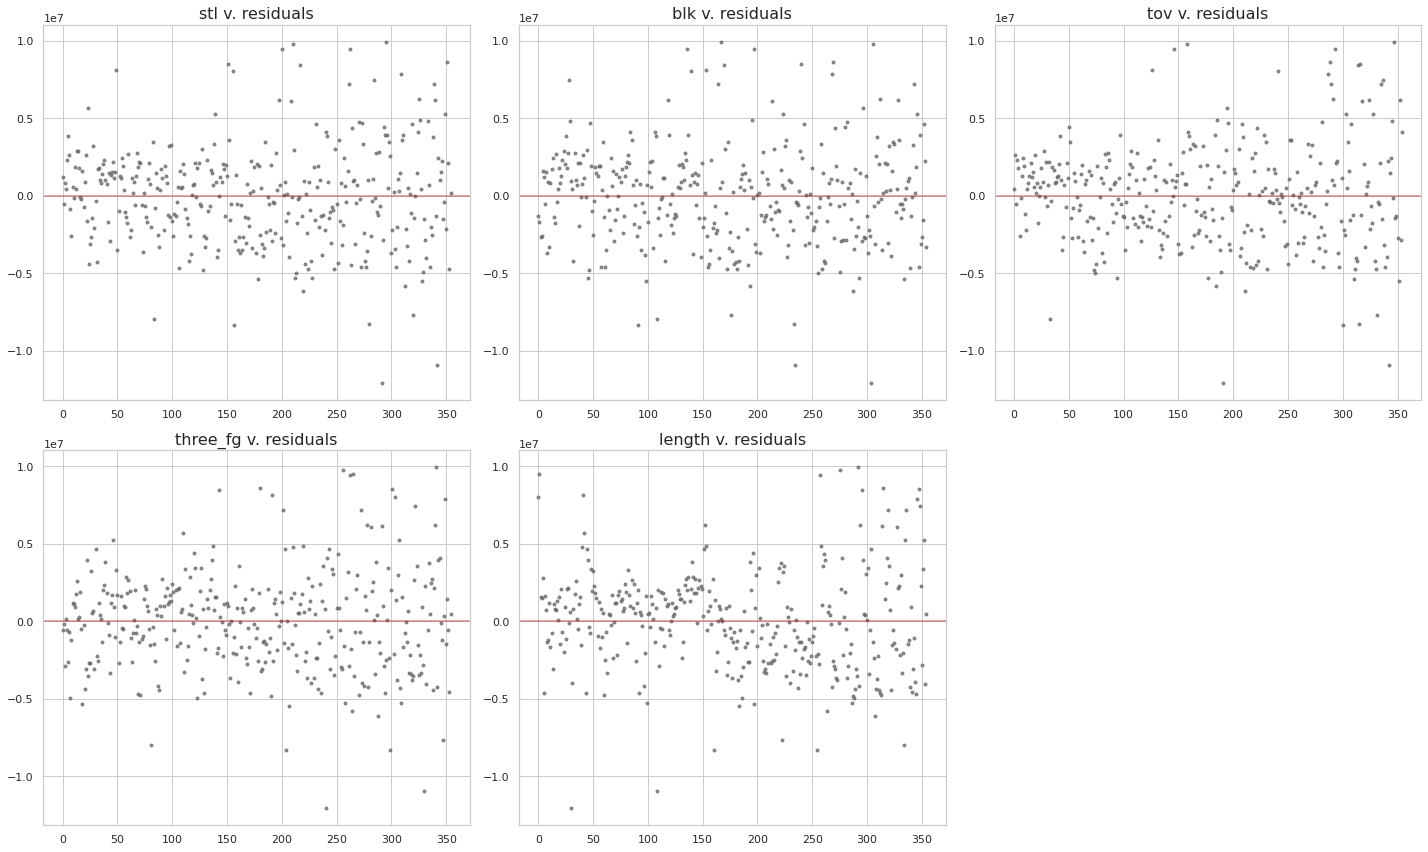

In [39]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

While there still appears to be a greater likelihood that large errors are made on the high end of the statistical values, it looks like this might have improved with this round of residual plots. This could be because players getting the most rebounds and blocks are tall and players getting the most assists and steals are shorter and the interaction terms have helped this.

At this point, I have not included an interaction term for points because teams want players that score no matter how tall they are. But I would like to experiment with what would have if I included an interaction term with points.

In [40]:
contracts['short:pts'] = contracts['short'] * contracts['pts']
contracts['tall:pts'] = contracts['tall'] * contracts['pts']

Running the model with this interaction term.

In [41]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-15,160,383.39","-43,692,461.08","2,548,037.94"
1,height,"96,136.57","-116,798.71","464,322.53"
2,age,"151,641.79","63,879.18","223,079.85"
3,min_sq,"-3,206.44","-6,843.80",338.83
4,pts_sq,"46,245.42","38,357.91","55,052.36"
5,rbs,"-20,555.26","-543,749.08","497,794.99"
6,ast,"1,546,090.61","440,985.23","2,757,737.61"
7,stl,"778,447.43","-1,586,233.95","3,162,236.13"
8,blk,"-1,254,283.37","-3,870,359.83","1,463,703.37"
9,tov,"-1,479,700.25","-3,040,805.67","276,134.50"


This model produces the best values of $R^2$, $\bar{R^2}$, and $\sigma$ yet. As switching from `pts` to `pts_sq` helped the model, what if I switched the interaction terms to use pts_sq?

In [42]:
contracts['short:pts_sq'] = contracts['short'] * contracts['pts_sq']
contracts['tall:pts_sq'] = contracts['tall'] * contracts['pts_sq']

Running the model with this interaction term.

In [43]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'short:pts_sq', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts_sq', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-15,956,148.19","-39,324,770.35","3,225,852.04"
1,height,"103,360.12","-131,849.44","429,324.46"
2,age,"148,123.27","72,530.30","275,944.59"
3,min_sq,"-3,855.14","-7,887.52",366.34
4,pts_sq,"43,973.04","32,381.96","56,096.66"
5,rbs,"95,531.01","-455,768.43","439,270.86"
6,ast,"1,777,340.58","876,317.76","3,136,436.19"
7,stl,"923,557.44","-1,447,619.73","3,283,565.89"
8,blk,"-1,278,018.04","-3,823,764.76","1,777,447.82"
9,tov,"-1,814,725.41","-3,160,271.29","-300,626.00"


While only slightly, this model does not perform as well. I will revert back to using the interaction terms with pts instead of pts_sq.

Switching from `min` and `pts` to `min_sq` and `pts_sq` really seemed to help the model. For experiment purposes, I want to try squaring the other statistical features to see if this will improve the model.

First, creating the new squared features:

In [44]:
contracts['rbs_sq'] = contracts['rbs']**2
contracts['ast_sq'] = contracts['ast']**2
contracts['stl_sq'] = contracts['stl']**2
contracts['blk_sq'] = contracts['blk']**2
contracts['tov_sq'] = contracts['tov']**2
contracts['three_fg_sq'] = contracts['three_fg']**2

Running the model with these features:

In [45]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-9,031,205.86","-32,284,740.32","9,386,711.27"
1,height,"25,034.79","-222,291.94","312,487.43"
2,age,"135,944.71","34,600.22","204,978.04"
3,min_sq,"-3,016.93","-5,709.23",55.36
4,pts_sq,"43,455.44","31,271.57","57,554.42"
5,rbs_sq,"3,629.18","-48,695.00","37,858.01"
6,ast_sq,"253,684.79","139,516.70","440,553.10"
7,stl_sq,"765,049.02","-740,992.55","1,897,679.56"
8,blk_sq,"-231,607.43","-1,766,258.03","2,203,148.41"
9,tov_sq,"-413,319.31","-1,107,564.28","383,036.70"


This increased the value of $R^2$ and slightly decreased the value for $\sigma$. However, the reason I switched to `min_sq` and `pts_sq` originally was due to the shape of the residual plots for `min` and `pts`. As tried these squared features to see what the results would be, I am very interested to see if and how this affected the residual plots before being sure this is the right adjustment to make.

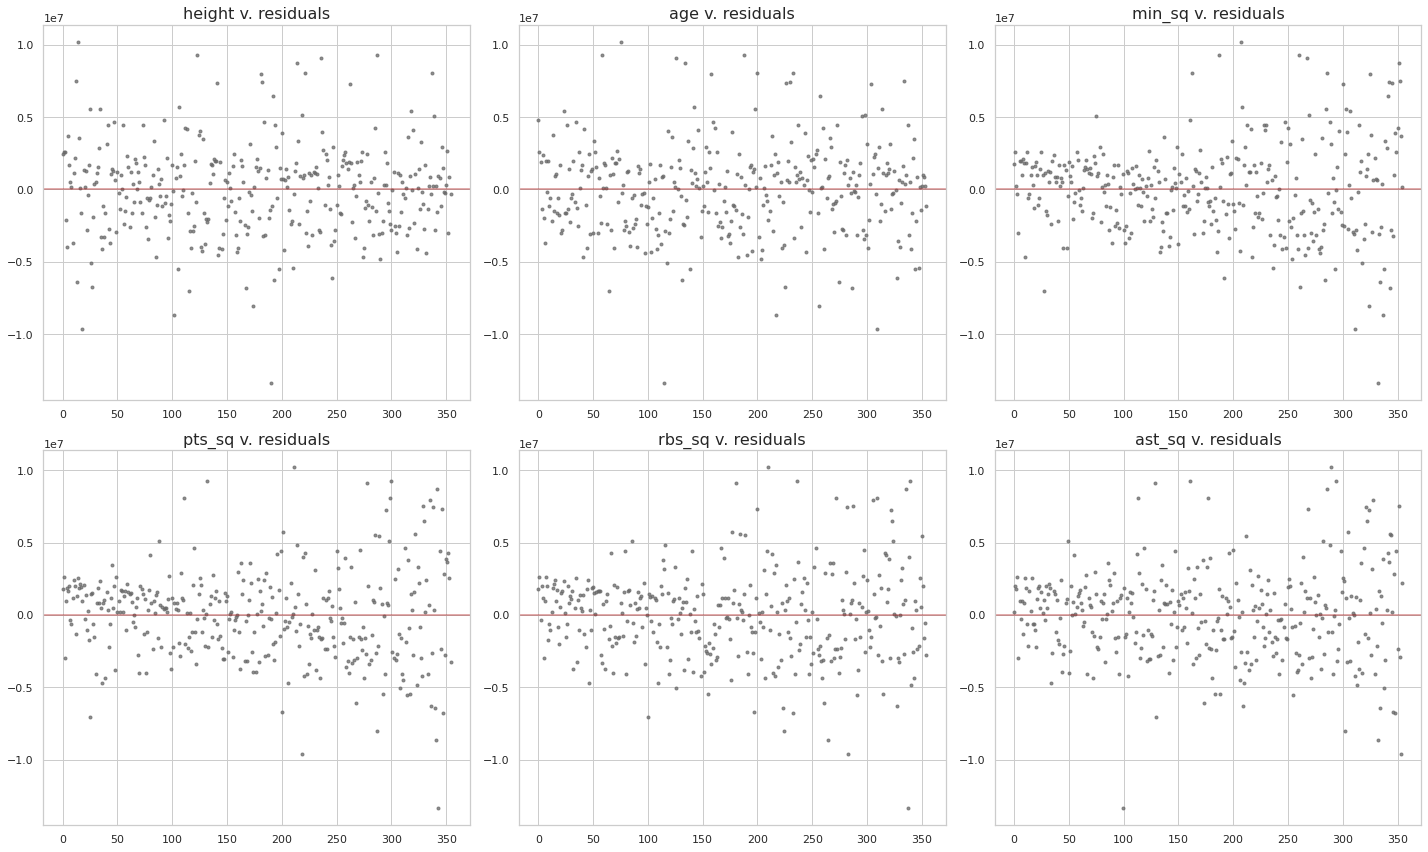

In [46]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs_sq', 'ast_sq'], result, (2, 3), size=(20,12))

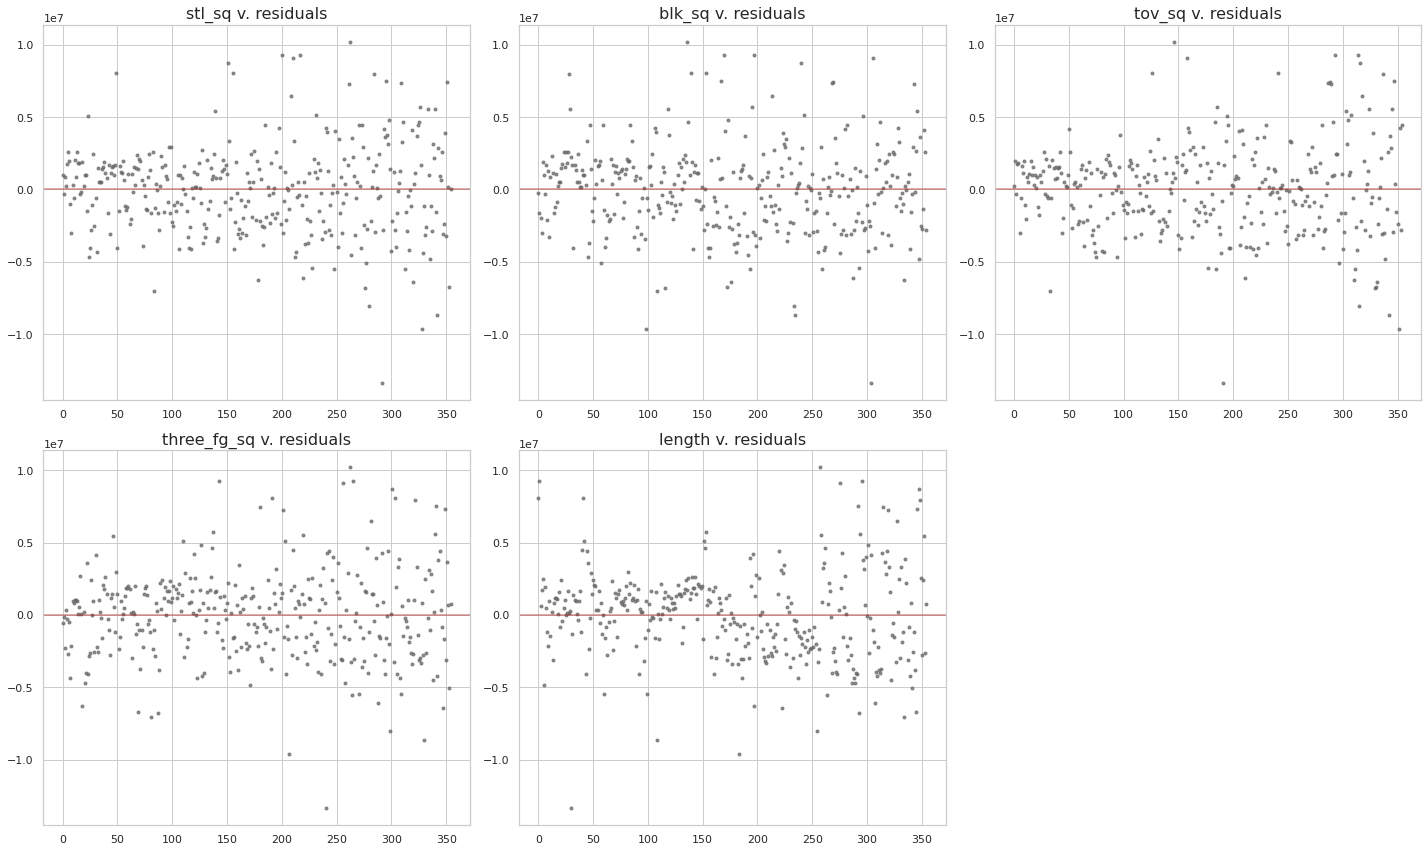

In [47]:
plot_residuals(contracts, ['stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq', 'length'], result, (2, 3), size=(20,12))

These residual plots look very similar to the model using the regular statistic features, so I think using these squared statistics is a good avenue to take.

I want to dive a little deeper into the `length` statistic. Length is a statistic that I passed over in EDA when comparing the different features to `avg_dollars` because I didn't think it would be very influential. However, as I think about it now, NBA contracts often fall into three categories: minimum contracts, medium contracts, and high contracts. Minimum contracts are for the lowest amount the team can offer the player and are used by teams to fill out their roster. These contracts are often for one year so teams can retain roster flexibility. High contracts are given to the best players. These players often want to lock in these high salaries for a longer time and thus, are often for 4 or 5 years. Medium contracts are for players who are definitely worth more than the minimum, but not quite worth a high contract. These contracts are often for two or three years, so the player can lock in some security but also allow himself to potentially sign a bigger contract in a few years if their play warrants it.

Because of this, I want to experiment with the idea of looking at `length` as a categorical variable. If different length contracts are correlated to different average salary ranges, this might be very beneficial to the model. To start, I want to plot side by side box plots of `length` and `avg_dollars` to see if this might be the case.

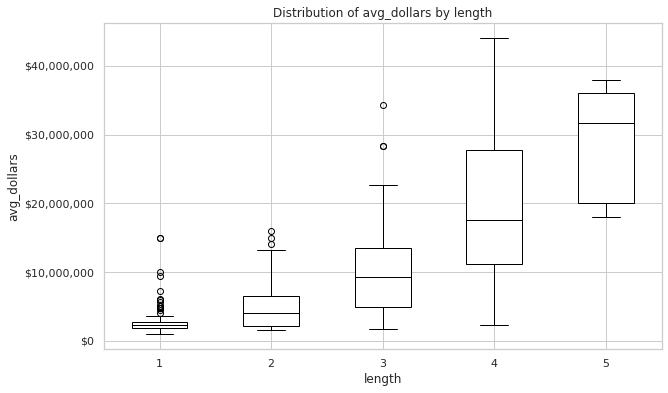

In [48]:
multiboxplot(contracts, 'avg_dollars', 'length', avg_dollars=True)

As a reminder from single variable EDA, it is important to remember that there are much less examples of 5 year contracts than the other contracts. However, based on the box plots, it might be beneficial for the model to know if a contract is 1 year, 2 or 3 years, or 4 or 5 years. The 1 year contracts are typically very, very low, which validates the claim that these are often minimum deals. The 4 and 5 year deals are often the big money deals, so this would also be helpful for the model.

Thus, I will try creating these features and see what the results are on the model.

In [49]:
contracts['one_yr'] = [1 if x==1 else 0 for x in contracts['length']]
contracts['four_five_yr'] = [1 if x>=4 else 0 for x in contracts['length']]
contracts['two_three_yr'] = [1 if x[0]+x[1] != 1 else 0 for x in zip(contracts['one_yr'], contracts['four_five_yr'])]

Checking the numbers in each contract length group:

In [50]:
print('1 year contracts:', contracts['one_yr'].value_counts()[1])
print('2 and 3 year contracts:', contracts['four_five_yr'].value_counts()[1])
print('4 and 5 year contracts:', contracts['two_three_yr'].value_counts()[1])

1 year contracts: 151
2 and 3 year contracts: 41
4 and 5 year contracts: 163


Now, I will insert these features into the model instead of `length`. From above, I know that the 2 and 3 year contracts group has the most contracts, but I will have the 1 year contract feature be the one I leave out of the model. This is because these should be the lowest value contracts. This means `two_three_yr` should have a positive coefficient and `four_five_yr` should have a larger positive coefficient.

In [51]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"1,368,903.29","-18,794,312.34","25,877,910.38"
1,height,"-56,152.42","-362,410.61","199,217.08"
2,age,"113,453.06","-1,071.58","199,862.09"
3,min_sq,"-1,221.04","-4,067.77","3,211.86"
4,pts_sq,"44,396.45","32,053.51","59,719.12"
5,rbs_sq,"18,671.80","-39,006.56","81,311.77"
6,ast_sq,"227,890.90","87,093.78","437,028.28"
7,stl_sq,"592,871.68","-1,408,235.82","1,597,139.56"
8,blk_sq,"-476,882.19","-2,297,176.58","1,493,891.01"
9,tov_sq,"-549,891.62","-1,212,262.26","296,768.46"


Although my prediction about the coefficients was correct, this model performs worse than previous model. What if I added length into the model as well?

In [52]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-11,686,654.34","-36,039,910.51","3,805,119.87"
1,height,"57,278.89","-132,648.85","374,837.72"
2,age,"116,477.02","13,690.70","171,156.27"
3,min_sq,"-2,137.18","-5,094.43",782.07
4,pts_sq,"40,378.57","30,430.57","52,491.43"
5,rbs_sq,"6,432.15","-44,141.33","47,819.01"
6,ast_sq,"241,141.08","133,077.61","474,442.37"
7,stl_sq,"929,328.89","-666,438.23","2,085,633.54"
8,blk_sq,"-376,273.28","-1,855,860.82","1,171,386.28"
9,tov_sq,"-434,654.38","-1,080,456.82","255,667.16"


This model provides the best results so far, with an $R^2$ of 0.85, $\bar{R^2}$ of 0.84 and $\sigma$ of just under 3.15 million. Taking a look at the residual plots:

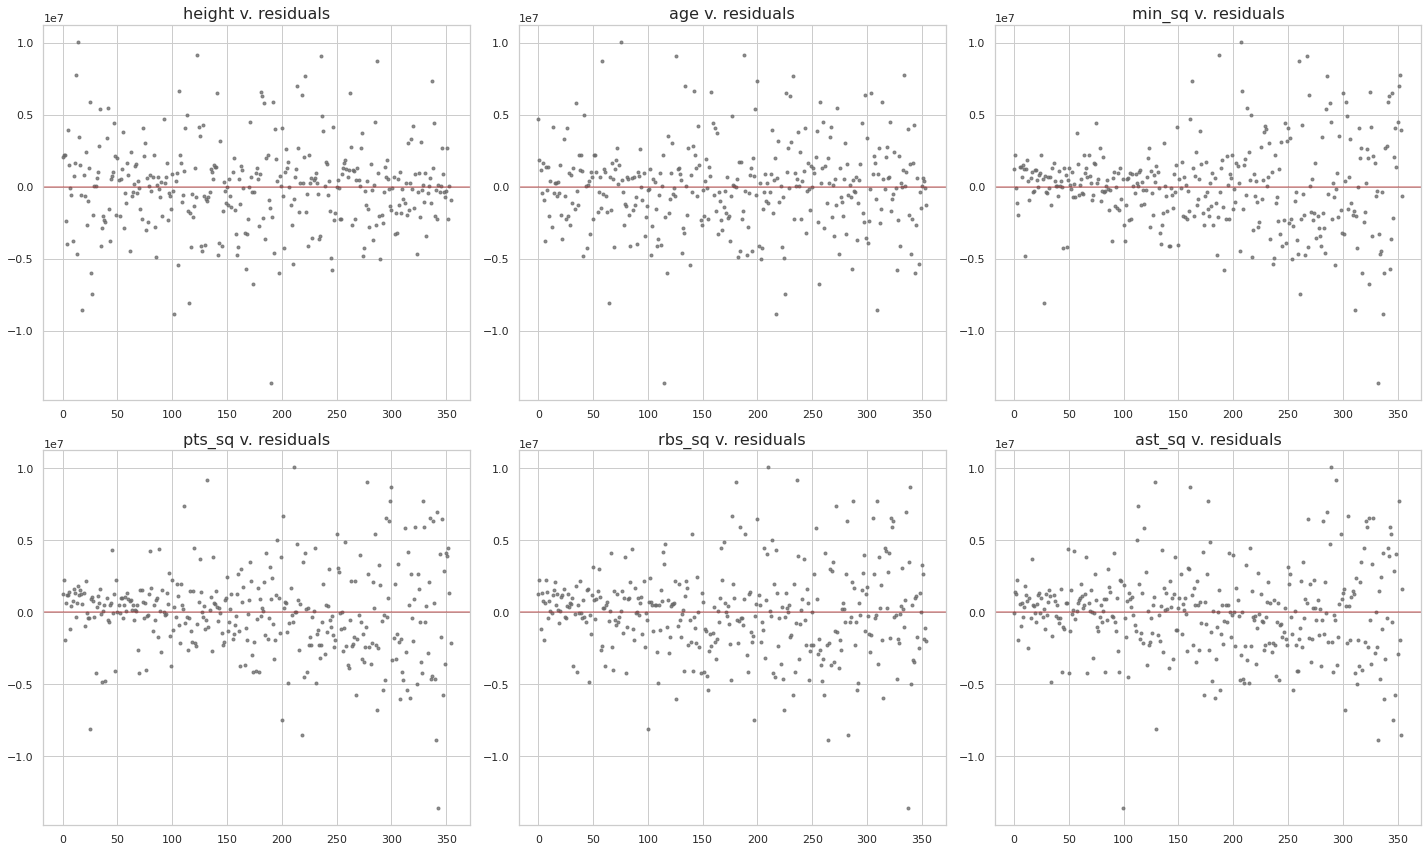

In [53]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs_sq', 'ast_sq'], result, (2, 3), size=(20,12))

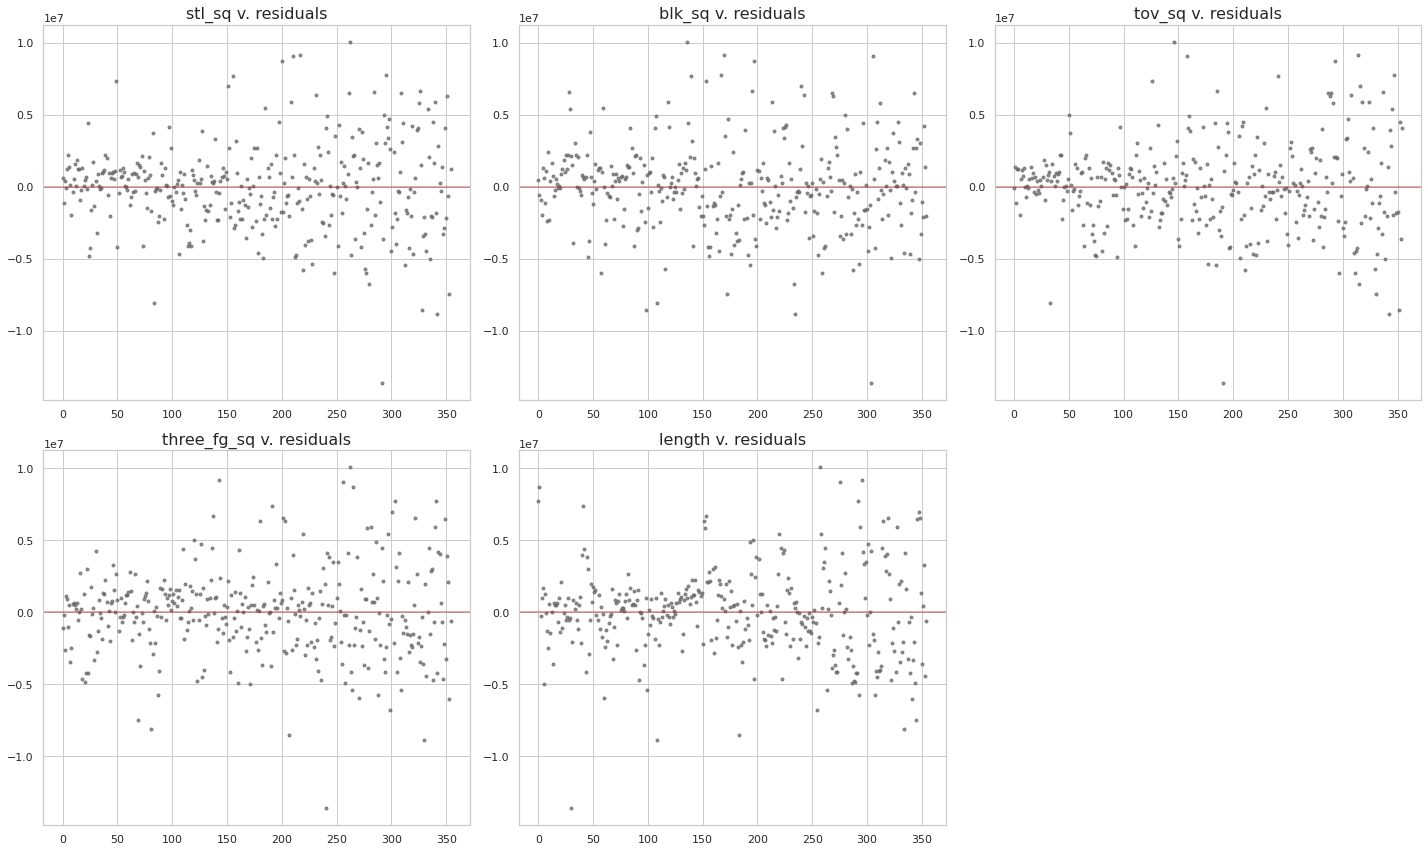

In [54]:
plot_residuals(contracts, ['stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq', 'length'], result, (2, 3), size=(20,12))

These residual plots look very similar to the ones in the recent models I have been working with.

One final thing to note about length: All of the other features are things that we would know about the player before signing the new contract, such as personal information, statistics, the type of contract they will be signing, and the fact that they are changing teams. The length of the contract, like average dollars is something that will be discussed with the player in the negotiations, which means I am hesitant to include it in the model. What happens if I remove all length features from the model entirely?

In [55]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"3,585,265.46","-23,210,525.19","29,307,371.32"
1,height,"-33,926.85","-358,864.44","325,773.29"
2,age,"-10,227.35","-119,996.64","75,136.00"
3,min_sq,263.27,"-4,493.88","4,617.64"
4,pts_sq,"49,674.91","35,226.75","65,268.01"
5,rbs_sq,"38,686.73","-25,151.40","91,791.93"
6,ast_sq,"350,682.65","184,534.63","630,420.44"
7,stl_sq,"88,544.10","-2,295,355.30","2,123,013.58"
8,blk_sq,"-546,132.46","-2,891,326.15","3,495,895.62"
9,tov_sq,"-790,450.43","-1,654,007.57","104,523.50"


The performance of the model worsens significantly, so I will leave these features in the model. But this is definitely something I will need to keep in the back of my head.

Lastly, after adding all the interaction terms, I want to take one final look at the coefficients, specifically the ones that differ from my original predictions.

In [56]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-11,686,654.34","-30,007,107.76","4,024,129.44"
1,height,"57,278.89","-161,510.45","282,675.48"
2,age,"116,477.02","35,967.47","206,470.51"
3,min_sq,"-2,137.18","-5,639.22",519.30
4,pts_sq,"40,378.57","28,093.95","52,866.59"
5,rbs_sq,"6,432.15","-38,040.48","43,529.13"
6,ast_sq,"241,141.08","129,077.60","373,061.56"
7,stl_sq,"929,328.89","-655,278.72","2,419,147.28"
8,blk_sq,"-376,273.28","-2,102,486.59","2,165,780.06"
9,tov_sq,"-434,654.38","-1,204,161.13","304,045.97"


The coefficients for min_sq, blk_sq, tov_sq, three_fg_sq, type, chg_team, two_three_year, and four_five year are all different signs than I would have expected. Since their Bayesian Credible Intervals contain zero, let's see how the model runs if I remove these features entirely from the model.

In [57]:
X = ['height', 'age', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq',
     'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-8,960,022.70","-28,723,182.24","10,514,446.34"
1,height,"27,592.64","-206,762.42","278,876.50"
2,age,"114,911.59","26,458.70","194,511.13"
3,pts_sq,"37,485.07","27,968.73","46,351.60"
4,rbs_sq,"-12,369.51","-47,959.93","26,935.17"
5,ast_sq,"225,707.37","122,813.87","389,499.36"
6,stl_sq,"424,599.71","-911,262.42","2,085,282.45"
7,length,"3,010,718.94","2,451,710.67","3,626,435.51"
8,short:pts,"-421,964.70","-847,447.36","41,506.02"
9,short:rbs,"542,846.53","-969,962.74","2,350,250.93"


The model does perform slightly worse than the last model. Let's take a look at the residual plot.

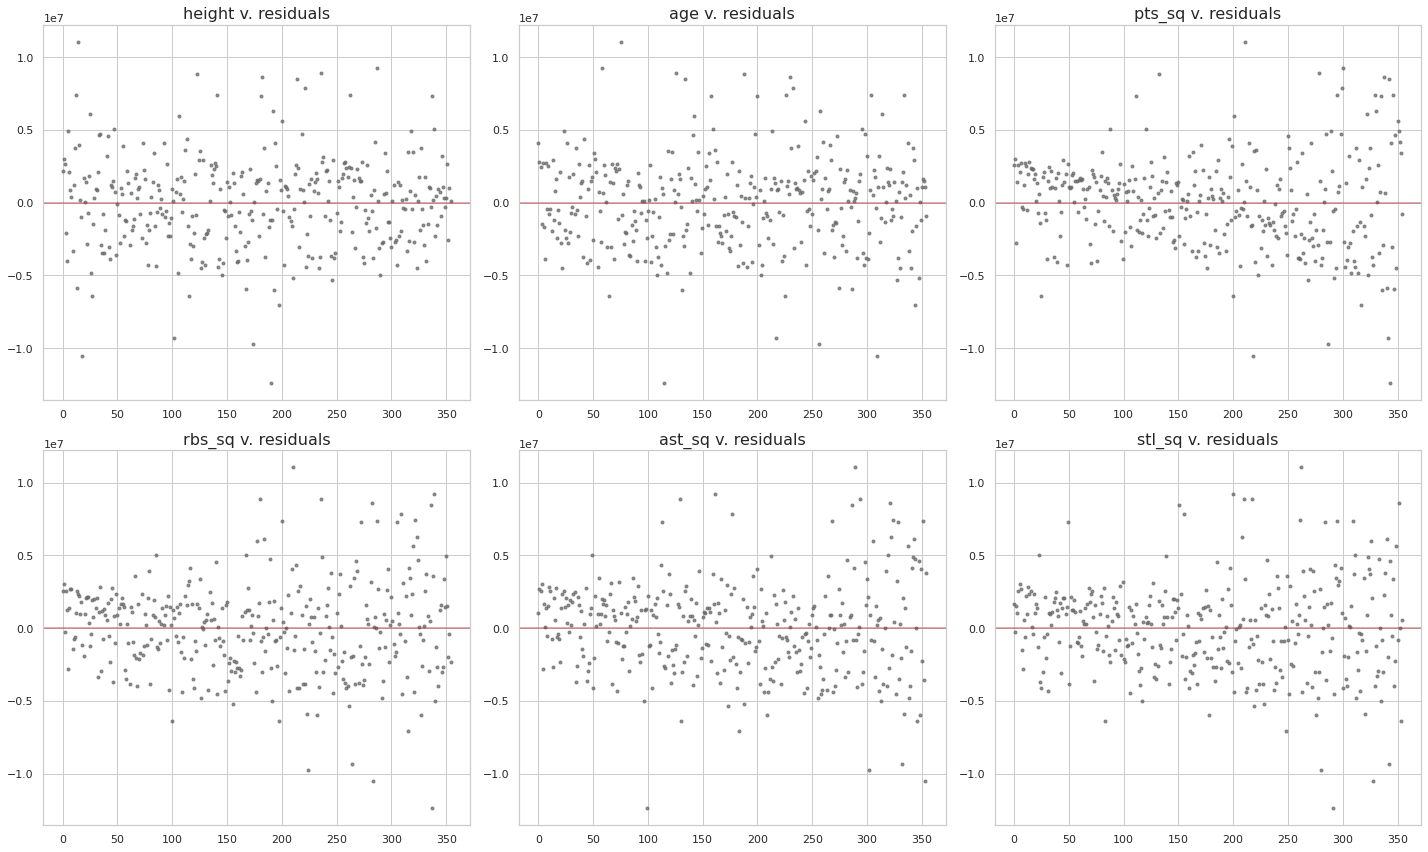

In [58]:
plot_residuals(contracts, ['height', 'age', 'pts_sq', 'rbs_sq', 'ast_sq', 'stl_sq'], result, (2, 3), size=(20,12))

These residual plots still look very similar to the previous model, as the higher errors are occuring at the higher values for each feature. Because the values of $R^2$, $\bar{R^2}$, and $\sigma$ all worsened, I will revert back to the previous model.

In [59]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']

### Model Evaluation

**Validation Curves**

For model evaluation, I am going to start by using validation curves to decide the best exponent to raise `pts` to. So far I have used `pts_sq` and normally validation curves are not used to pick the power to which you raise a feature. However, because points is so highly correlated with avg_dollars compared to the other features, I want to make sure squaring points is the right thing to do.

First I will make some additional features that relate to different powers of pts.

In [60]:
contracts['pts_3'] = contracts['pts']**3
contracts['pts_4'] = contracts['pts']**4
contracts['pts_5'] = contracts['pts']**5
contracts['pts_6'] = contracts['pts']**6
contracts['pts_7'] = contracts['pts']**7
contracts['pts_8'] = contracts['pts']**8
contracts['pts_9'] = contracts['pts']**9

Next, I need to set X to include all the features in the model except for `pts_sq`.

In [61]:
X_no_pts = ['height', 'age', 'min_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']

Next I will calculate and plot validation curves where the model performs cross validation on different models, where each model contains a different points feature.

In [62]:
result = validation_curves_features(contracts, X_no_pts, y,
                                    [['pts'], ['pts_sq'], ['pts_3'], ['pts_4'], ['pts_5'], ['pts_6'], ['pts_7'], ['pts_8'], ['pts_9']],
                                    lambda x: (x['sigma']), fold_count=10, seed=14141423)

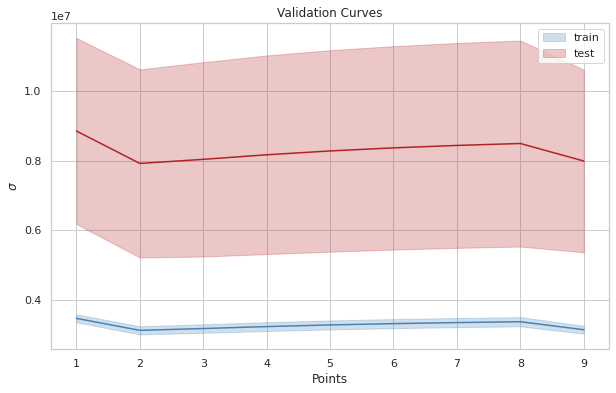

In [63]:
plot_validation_curves(result, '$\sigma$', 'Points', list(range(1,10)))

We see here that $\sigma$ is at a minimum when points is squared. Originally, I chose to square points based on the shape of the residual plot and what I saw in EDA. If another feature had shown a lower $\sigma$, I would have considered using it only after looking at the residual plots and the effect it had on the model. Nevertheless, seeing that the minimum $\sigma$ is achieved with points squared is good and I will proceed.

**k Fold Cross Validation**

Next, I would like to perform k fold cross validation on the model to test how the model performs against unseen data. To start, I will perform 3 repititions of 10 fold cross validation.

In [64]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=10, seed=14141424)

We can look at the mean $\sigma$ across the cross validation.

In [65]:
print("mean sigma: ", np.mean(result))

mean sigma:  6968032.953670354


The mean $\sigma$ is just under 7 million dollars. To be honest, this is higher than expected, especially since the $\sigma$ for the model was around 3.1 million dollars. This means that the model performs much worse on data that it has not seen, which is not great.

Let's see what happens if I change the fold count to 5.

In [66]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=5, seed=14141425)
print("mean sigma: ", np.mean(result))

mean sigma:  3990527.7378494716


Interesting. Even though the model trains on less data, the mean $\sigma$ is lower. What if I do a fold count of 3?

In [67]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=3, seed=14141426)
print("mean sigma: ", np.mean(result))

mean sigma:  3678239.9477819535


This $\sigma$ is even better. Unfortunately, due to the relatively small size of the data set, I cannot test larger values for the fold count. This is because if I increase the number of folds there will be less observations than features, which is no good.

My interpretation of this is that the there are some observations that the model does exceptionally bad on. When the number of folds is high, there are a low number of observations in the test set. If one of these observations is in this small test set, then that value of $\sigma$ is going to be contributing to the mean $\sigma$. As there are not that many test observations, there are less observations to balance out the overall average.

For now, I will move forward using 8 folds.

In [68]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=8, seed=14141427)
print("mean sigma: ", np.mean(result))

mean sigma:  5061699.763413427


Also, I can estimate creible bounds, as 3 rounds of 10 fold cross validation is essentially a Bootstrap estimate of the metric.

In [69]:
print(r"95% CI for sigma:", stats.mstats.mquantiles(result, [0.025, 0.975]))

95% CI for sigma: [4004171.59578246 6312499.01755691]


Also, I can take a bootstrap of the results to estimate the average performance of the model when performing 3 repetitions of 10 fold cross validation on this data. I will take the 1000 random samples of the `result` array and compute the mean of this sample.

In [70]:
np.random.seed(14)

bootstrap_sigma = np.array([np.mean(s) for s in [resample(result) for i in range( 0, 1000)]])

I can use these Bootstraps to compute the 95% Credible Intervals for $\sigma$

In [71]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap_sigma, [0.025, 0.975]))

95% CI for *mean* sigma: [4790489.70839021 5349291.54636237]


The 95% Credible Interval for \*mean\* $\sigma$ is between 4.79 million and 5.35 million. This means that there is a 95% chance that the true \*mean\* $\sigma$ for this model when performing 3 repetitions of 8 fold cross validation on this data is between 4.79 and 5.35 million.

**Learning Curves**

Next, I want to use learning curves to assess the bias/variance tradeoff and ways to potentially improve the model.

In [72]:
result = learning_curves(contracts, X, y, lambda r: r["sigma"], fold_count=8, increment=4, seed=14141429)

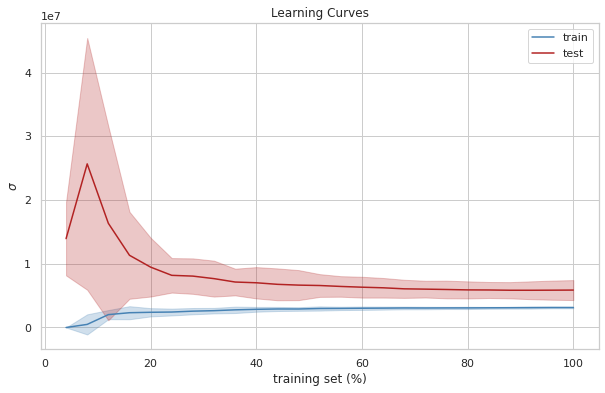

In [73]:
plot_learning_curves(result, r'$\sigma$')

From this view, it seems as if the values of $\sigma$ have leveled off for both the training set and the test set. However, this is a weird scale, so zooming in might help to see this better.

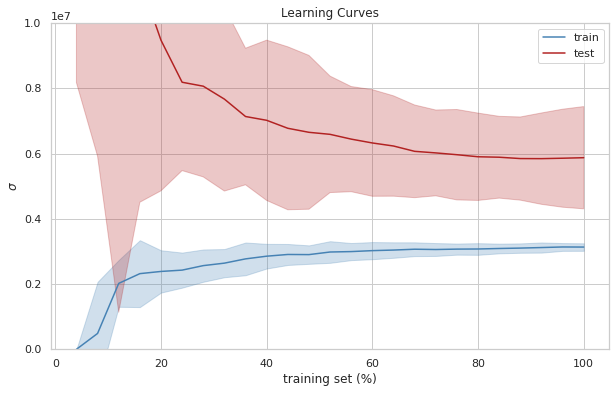

In [74]:
plot_learning_curves(result, r'$\sigma$', zoom=(0,10000000))

While the values of $\sigma$ do not level off quite as quickly as it appeared in the last view, they do seem to level off after the training set is 80% of the training set chunk. For experiment sake, what would have if we looked at 10 fold cross validation instead of 8?

In [75]:
result = learning_curves(contracts, X, y, lambda r: r["sigma"], fold_count=10, increment=4, seed=14141429)

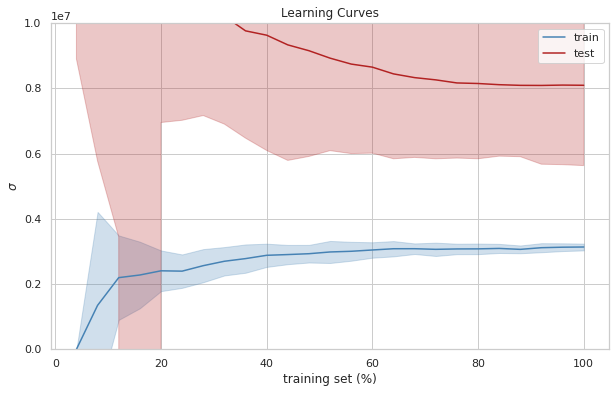

In [76]:
plot_learning_curves(result, r'$\sigma$', zoom=(0,10000000))

We can see again that values of $\sigma$ do level off around the 80% of the training set mark. However, as expected with this particular model and data set, the value for $\sigma$ is higher for the 10 fold cross validation.

In terms of bias/variance tradeoff, the model leans on the bias side of the tradeoff. I think this because the values displayed in the learning curve have leveled off before reaching 100% of the trading set. Thus, adding data likely would not make a huge difference. Ultimately, the success of the model comes down to if it is at or below the accepted error. If we said the accepted error was $\sigma = 5,000,000$:

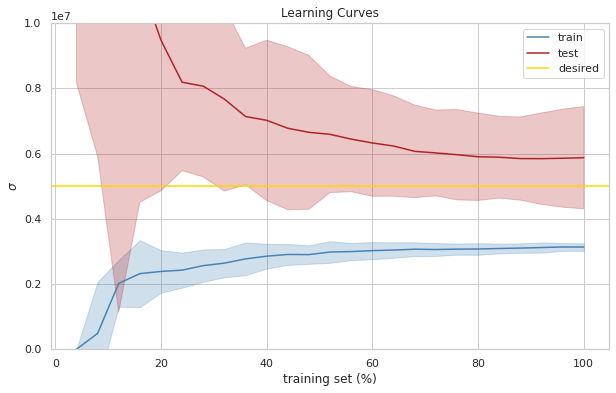

In [77]:
result = learning_curves(contracts, X, y, lambda r: r["sigma"], fold_count=8, increment=4, seed=14141429)
plot_learning_curves(result, r'$\sigma$', desired=5000000, zoom=(0,10000000))

We can see that model 5 million is in the credible interval for the test set, but it the actual value of $\sigma$ is above it around 6 million. The training set value for $\sigma$ is way below this. If I wanted to try and improve this model, I would look to add more features, maybe by finding more statistics to use, or decreasing regularization. I will also add that while this learning curve shows tht getting more data might not help the model that much, it would be nice to have slighly bigger test sets when running cross validation, espicially based on the number of features in the model. Therefore, if data on free agents was able further back than the last 3 seasons, that would be nice to get.

## Final Thoughts

Ultimately, the Linear Regression model that I created has decent values for $R^2$, $\bar{R^2}$, and $\sigma$. However, the value for $\sigma$ is not as good when tested on unseen data. The model tends to perform worst on data that is near the higher values for different statistical categories, such as points or rebounds. We see this in the residual plots for these statistics. Thus, the model probably performs worst on players who are set to receive larger contracts. There is a general concesus in the league as to which players will receive "max" contracts. Thus, the model may not be needed for these particular players, which is where the model performs the worst. The situations where the model is needed is for players that will be receiving between minimum and maximum contracts. This model likely performs much better for these players.

In [78]:
con.close()